In [1]:
!unzip AP3-zipped.zip
%cd AP3

Archive:  AP3-zipped.zip
  inflating: AP3/classify.ipynb      
  inflating: AP3/jeopardy.csv        
  inflating: AP3/model.csv           
   creating: AP3/splits/
  inflating: AP3/splits/dev.txt      
  inflating: AP3/splits/test.txt     
  inflating: AP3/splits/train.txt    
   creating: AP3/transformers/
/content/AP3


In [25]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tf_keras.callbacks import CSVLogger, ModelCheckpoint
import tf_keras
import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
import math

In [3]:
jeopardy = pd.read_csv('jeopardy.csv')
train, other = train_test_split(jeopardy, test_size=0.4, random_state=42, stratify=jeopardy['class'])
dev, test = train_test_split(other, test_size=0.5, random_state=42, stratify=other['class'])
train.to_csv('splits/train.txt', index=False)
dev.to_csv('splits/dev.txt', index=False)
test.to_csv('splits/test.txt', index=False)

## BERT

In [4]:
# Function to preprocess and encode datasets
def prepare_data(data):
    data['combined_text'] = data['Category'] + " [SEP] " + data['Question'] + " [SEP] " + data['Answer']
    # Ensure to use the 'text' parameter for the tokenizer
    input_data = tokenizer(text=data['combined_text'].tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="tf")
    labels = label_encoder.transform(data['class'])  # Transform labels using the fitted label encoder
    return input_data['input_ids'], tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))


model_name = 'distilbert-base-uncased'
# Initialize and fit label encoder on all possible labels
label_encoder = LabelEncoder()
all_data = pd.concat([train, dev, test])
label_encoder.fit(all_data['class'])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# Initialize model
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Prepare datasets
train_inputs, train_labels = prepare_data(train)
dev_inputs, dev_labels = prepare_data(dev)
test_inputs, test_labels = prepare_data(test)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(len(train_labels)).batch(32)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)



# Compile model
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf_keras.optimizers.legacy.Adam(learning_rate=1e-5)
csv_logger = CSVLogger("model.csv")
checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train model
model.fit(train_dataset, epochs=25, validation_data=dev_dataset, callbacks=[csv_logger, checkpoint])

# Evaluate model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/25


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
10/10 [==============================] - ETA: 0s - loss: 1.2563 - accuracy: 0.5567
Epoch 1: val_loss improved from inf to 1.10454, saving model to model.keras
10/10 [==============================] - 74s 1s/step - loss: 1.2563 - accuracy: 0.5567 - val_loss: 1.1045 - val_accuracy: 0.6400
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 1.0523 - accuracy: 0.6433
Epoch 2: val_loss improved from 1.10454 to 1.02039, saving model to model.keras
10/10 [==============================] - 5s 542ms/step - loss: 1.0523 - accuracy: 0.6433 - val_loss: 1.0204 - val_accuracy: 0.6400
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.6433
Epoch 3: val_loss improved from 1.02039 to 1.00629, saving model to model.keras
10/10 [==============================] - 5s 545ms/step - loss: 1.0085 - accuracy: 0.6433 - val_

In [5]:
majority_class = test['class'].value_counts().idxmax()
majority_class_accuracy = (test['class'] == majority_class).mean()
print(f"Majority Class Baseline: {majority_class_accuracy}")

Majority Class Baseline: 0.65


In [29]:
# Confidence interval function from example notebooks
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*stats.norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

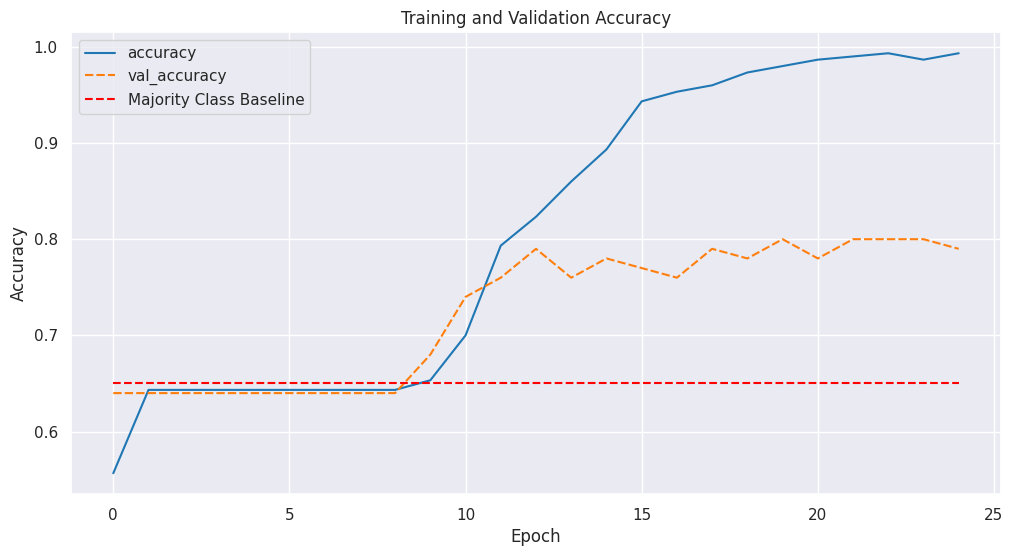

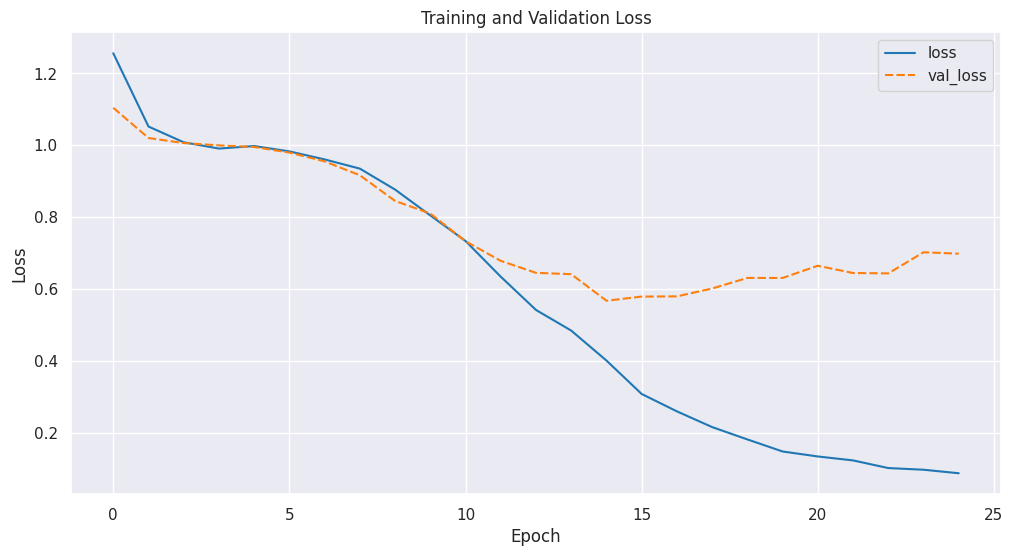

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', palette="tab10", context='notebook')
performance = pd.read_csv('model.csv')
performance['epoch'] = performance.index + 1
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance[['accuracy', 'val_accuracy']])
plt.hlines(majority_class_accuracy, color='red', linestyles='dashed', label='Majority Class Baseline', xmin=0, xmax=len(performance)-1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance[['loss', 'val_loss']])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
preds = model.predict(test_inputs)
classes = label_encoder.classes_
y_hat = classes[np.argmax(preds.logits, axis=1)]
y = label_encoder.inverse_transform(np.argmax(test_labels, axis=1))

4/4 [==============================] - 0s 101ms/step


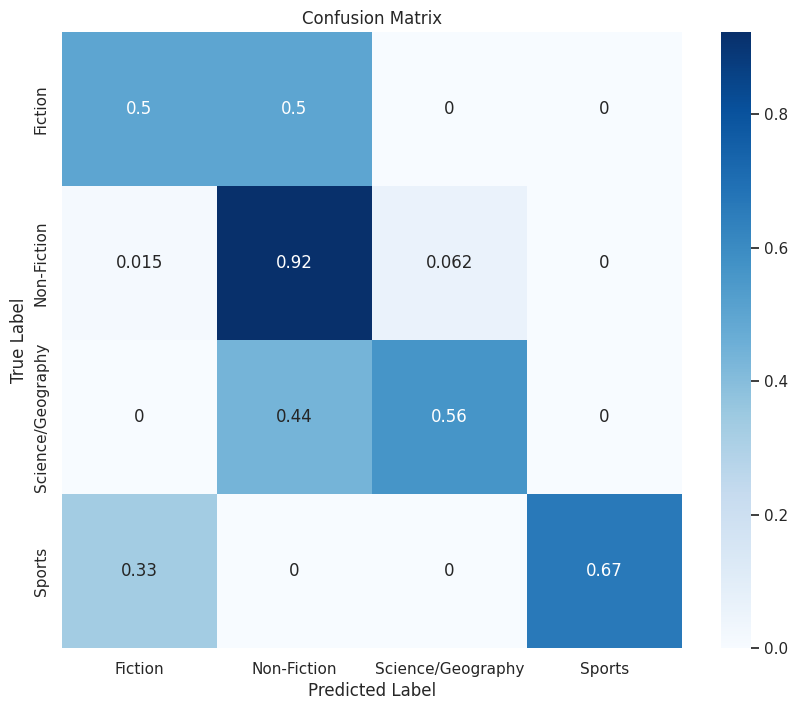

In [32]:
# make confusion matrix using sklearn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_hat, labels=classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
confidence_intervals(test_accuracy, len(test_inputs), 0.95)

(0.5993529900246857, 0.7806470099753142)

## SVM

Development Set Accuracy: 0.65
                   precision    recall  f1-score   support

          Fiction       1.00      0.06      0.11        17
      Non-Fiction       0.65      1.00      0.79        64
Science/Geography       0.00      0.00      0.00        15
           Sports       0.00      0.00      0.00         4

         accuracy                           0.65       100
        macro avg       0.41      0.26      0.22       100
     weighted avg       0.58      0.65      0.52       100

Test Set Accuracy: 0.67
                   precision    recall  f1-score   support

          Fiction       1.00      0.12      0.22        16
      Non-Fiction       0.66      1.00      0.80        65
Science/Geography       0.00      0.00      0.00        16
           Sports       0.00      0.00      0.00         3

         accuracy                           0.67       100
        macro avg       0.42      0.28      0.25       100
     weighted avg       0.59      0.67      0.55       

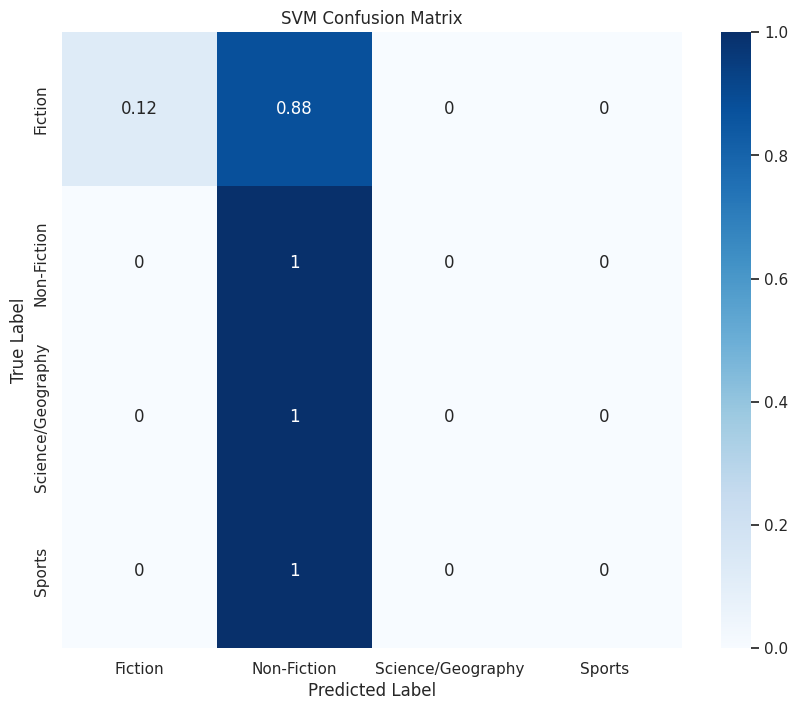

In [34]:
for data in [train, dev, test]:
    data['text'] = data['Category'] + " [SEP] " + data['Question'] + " [SEP] " + data['Answer']

# Prepare the features and labels for each set
X_train = train['text']
y_train = train['class']
X_dev = dev['text']
y_dev = dev['class']
X_test = test['text']
y_test = test['class']

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Transform features into TF-IDF coefficients
X_train = vectorizer.fit_transform(X_train)
X_dev = vectorizer.transform(X_dev)
X_test = vectorizer.transform(X_test)

# Initialize the SVM classifier
svm = SVC(kernel='sigmoid', random_state=42)

# Train the model using the training set
svm.fit(X_train, y_train)

# Validate the model using the development set
dev_predictions = svm.predict(X_dev)
dev_accuracy = accuracy_score(y_dev, dev_predictions)
print(f'Development Set Accuracy: {dev_accuracy}')
print(classification_report(y_dev, dev_predictions))

# Finally, evaluate the model using the test set
test_predictions = svm.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Set Accuracy: {test_accuracy}')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test, test_predictions, labels=classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

In [35]:
confidence_intervals(test_accuracy, len(test_inputs), 0.95)

(0.5778400007999419, 0.7621599992000582)

## Random Forests

Development Set Accuracy: 0.66
                   precision    recall  f1-score   support

          Fiction       1.00      0.06      0.11        17
      Non-Fiction       0.65      1.00      0.79        64
Science/Geography       1.00      0.07      0.12        15
           Sports       0.00      0.00      0.00         4

         accuracy                           0.66       100
        macro avg       0.66      0.28      0.26       100
     weighted avg       0.74      0.66      0.54       100

Test Set Accuracy: 0.64
                   precision    recall  f1-score   support

          Fiction       0.67      0.12      0.21        16
      Non-Fiction       0.65      0.95      0.78        65
Science/Geography       0.00      0.00      0.00        16
           Sports       0.00      0.00      0.00         3

         accuracy                           0.64       100
        macro avg       0.33      0.27      0.25       100
     weighted avg       0.53      0.64      0.54       

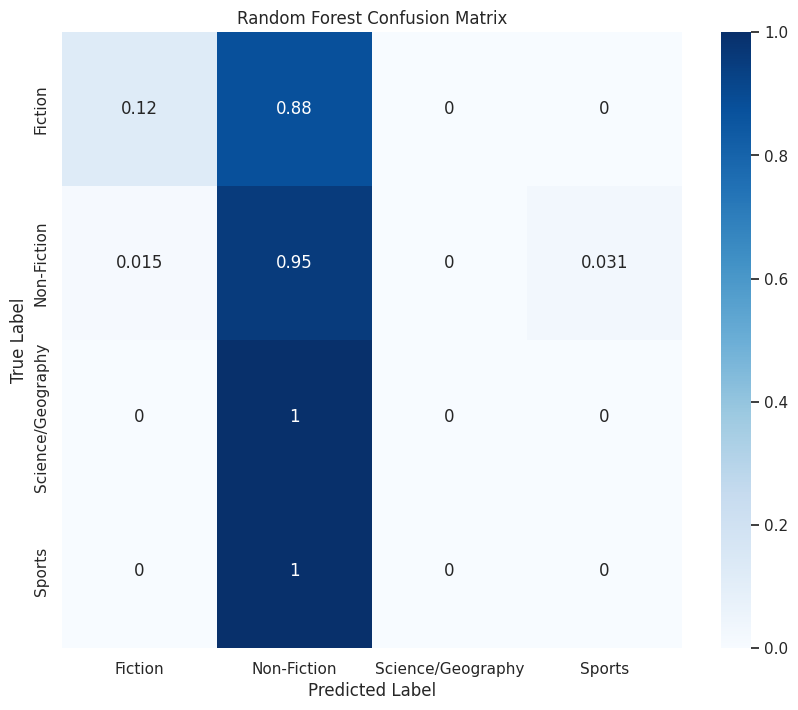

In [36]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model using the training set
random_forest.fit(X_train, y_train)

# Validate the model using the development set
dev_predictions = random_forest.predict(X_dev)
dev_accuracy = accuracy_score(y_dev, dev_predictions)
print(f'Development Set Accuracy: {dev_accuracy}')
print(classification_report(y_dev, dev_predictions))

# Finally, evaluate the model using the test set
test_predictions = random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Set Accuracy: {test_accuracy}')
print(classification_report(y_test, test_predictions))

cm = confusion_matrix(y_test, test_predictions, labels=classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [37]:
confidence_intervals(test_accuracy, len(test_inputs), 0.95)

(0.5459217287420775, 0.7340782712579226)

## Logistic Regression

Development Set Accuracy: 0.64
                   precision    recall  f1-score   support

          Fiction       0.00      0.00      0.00        17
      Non-Fiction       0.64      1.00      0.78        64
Science/Geography       0.00      0.00      0.00        15
           Sports       0.00      0.00      0.00         4

         accuracy                           0.64       100
        macro avg       0.16      0.25      0.20       100
     weighted avg       0.41      0.64      0.50       100

Test Set Accuracy: 0.65
                   precision    recall  f1-score   support

          Fiction       0.00      0.00      0.00        16
      Non-Fiction       0.65      1.00      0.79        65
Science/Geography       0.00      0.00      0.00        16
           Sports       0.00      0.00      0.00         3

         accuracy                           0.65       100
        macro avg       0.16      0.25      0.20       100
     weighted avg       0.42      0.65      0.51       

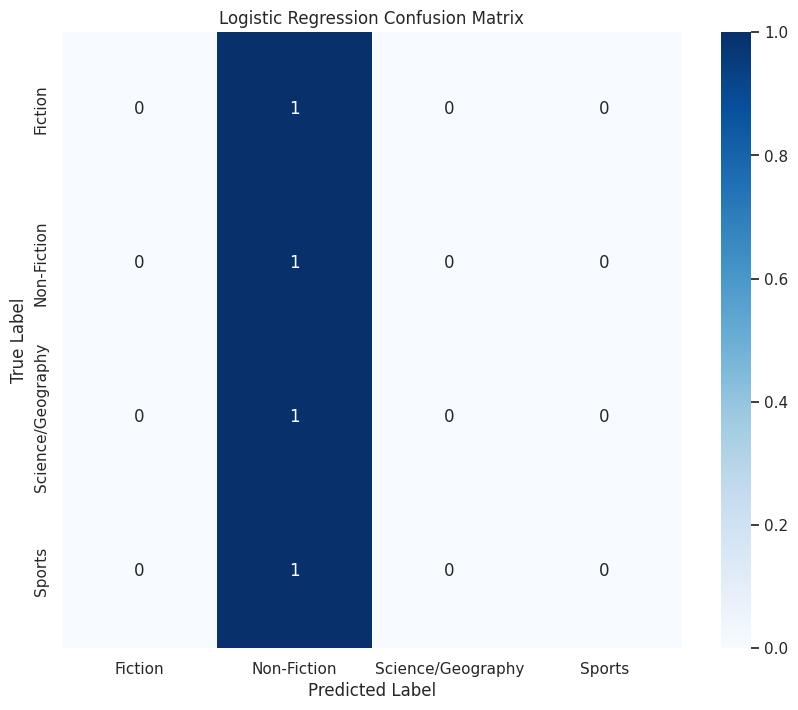

In [38]:
logistic_regression = LogisticRegression(max_iter=1000)

# Train the model using the training set
logistic_regression.fit(X_train, y_train)

# Validate the model using the development set
dev_predictions = logistic_regression.predict(X_dev)
dev_accuracy = accuracy_score(y_dev, dev_predictions)
print(f'Development Set Accuracy: {dev_accuracy}')
print(classification_report(y_dev, dev_predictions))

# Finally, evaluate the model using the test set
test_predictions = logistic_regression.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Set Accuracy: {test_accuracy}')
print(classification_report(y_test, test_predictions))

cm = confusion_matrix(y_test, test_predictions, labels=classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [39]:
confidence_intervals(test_accuracy, len(test_inputs), 0.95)

(0.5565156760890944, 0.7434843239109057)

## Balanced Logistic

Development Set Accuracy: 0.6
                   precision    recall  f1-score   support

          Fiction       0.25      0.18      0.21        17
      Non-Fiction       0.68      0.81      0.74        64
Science/Geography       0.50      0.33      0.40        15
           Sports       0.00      0.00      0.00         4

         accuracy                           0.60       100
        macro avg       0.36      0.33      0.34       100
     weighted avg       0.55      0.60      0.57       100

Test Set Accuracy: 0.69
                   precision    recall  f1-score   support

          Fiction       0.78      0.44      0.56        16
      Non-Fiction       0.72      0.89      0.79        65
Science/Geography       0.40      0.25      0.31        16
           Sports       0.00      0.00      0.00         3

         accuracy                           0.69       100
        macro avg       0.47      0.39      0.42       100
     weighted avg       0.65      0.69      0.66       1

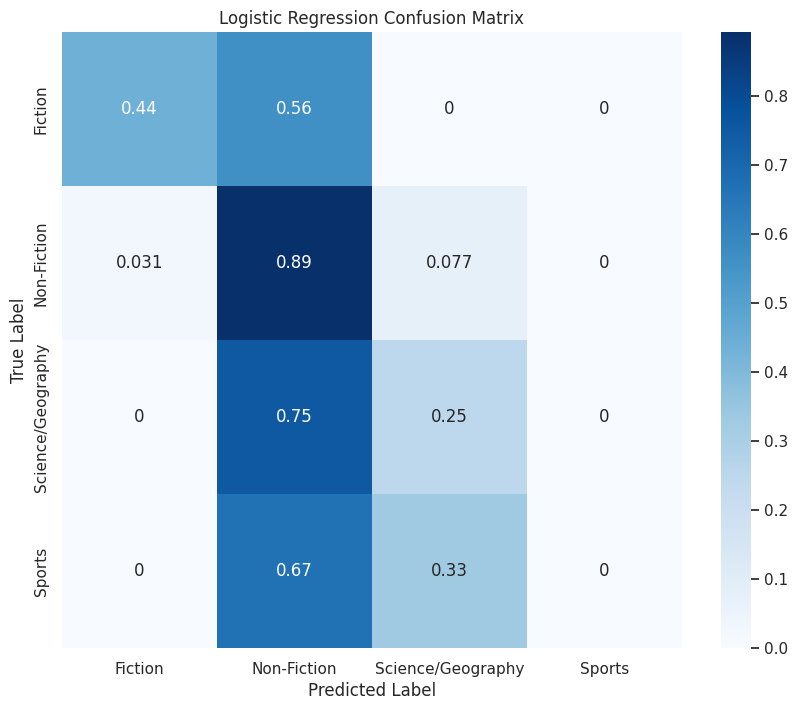

In [40]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model using the training set
logistic_regression.fit(X_train, y_train)

# Validate the model using the development set
dev_predictions = logistic_regression.predict(X_dev)
dev_accuracy = accuracy_score(y_dev, dev_predictions)
print(f'Development Set Accuracy: {dev_accuracy}')
print(classification_report(y_dev, dev_predictions))

# Finally, evaluate the model using the test set
test_predictions = logistic_regression.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Set Accuracy: {test_accuracy}')
print(classification_report(y_test, test_predictions))

cm = confusion_matrix(y_test, test_predictions, labels=classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [41]:
confidence_intervals(test_accuracy, len(test_inputs), 0.95)

(0.5993529900246857, 0.7806470099753142)